In [1]:
from importlib import reload
import backtest
import order_book
import signal_1
import scipy.odr as odr

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pickle
import os
import math
from ReferentialData.polygonData import PolygonAPI
from DataAnalysis import DataExtensions
from Filtering.KalmanFilter import KalmanFilter

In [3]:
# Loading "pairs trade" buckets
DIR = r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache'
COR_DIR = r'\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Clustering'
with open(os.path.join(COR_DIR, "correlation_buckets_no_shorts.pkl"), "rb") as file:
    BUCKETS = pickle.load(file)

In [4]:
# Concatenating dictionary value lists
UNIVERSE=[]
for i in list(BUCKETS.values()):
    UNIVERSE.extend(i)

In [5]:
colnames = ["Close", "Volume"]
DataLoader = PolygonAPI()
MID_LOADED = False
HIGH_LOADED = False
if not MID_LOADED:
    mid_df = {}
if not HIGH_LOADED:
    high_df = {}
### loading in low frequency data
if len(mid_df) == 0:
    mid_df = DataLoader.getPrices(UNIVERSE, "day", logDir=os.path.join(DIR,"Beta_Callibration"), _parallel=True)
    MID_LOADED = True

### loading in high frequency data
if len(high_df) == 0:
    high_df = DataLoader.getPrices(UNIVERSE, "minute", logDir=DIR, _parallel=True)
    HIGH_LOADED = True


## Analysis of first correlation bucket

In [6]:
BUCKETS

{'AOA': ['AOA', 'SPXS', 'SPXU', 'SH', 'SDS'],
 'AIQ': ['AIQ', 'SQQQ', 'QID', 'PSQ'],
 'AGQ': ['AGQ', 'ZSL'],
 'AGG': ['AGG', 'TTT', 'TYO', 'TMV', 'TBT', 'TBX', 'PST'],
 'ACWX': ['ACWX', 'EPV', 'EFZ', 'EFU'],
 'ACWI': ['ACWI', 'SPXU', 'SPXS', 'SH', 'SDS'],
 'AAXJ': ['AAXJ', 'EUM', 'EEV'],
 'ZSL': ['ZSL', 'SLV', 'SIVR', 'GLTR'],
 'ZROZ': ['ZROZ', 'TMV', 'TTT', 'TBT'],
 'XBI': ['XBI', 'LABD'],
 'YCL': ['YCL', 'YCS'],
 'YINN': ['YINN', 'YANG', 'YXI', 'FXP'],
 'YCS': ['YCS', 'FXY'],
 'YXI': ['YXI', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'YANG': ['YANG', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'XT': ['XT', 'HIBS'],
 'XTR': ['XTR', 'SQQQ', 'SPXS', 'SPXU', 'SH', 'SDS', 'QID', 'PSQ'],
 'XSOE': ['XSOE', 'EUM', 'EEV'],
 'XSVM': ['XSVM', 'TWM', 'TZA', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XSMO': ['XSMO', 'TZA', 'TWM', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XPP': ['XPP', 'FXP'],
 'XNTK': ['XNTK', 'SQQQ', 'SOXS', 'QID', 'PSQ'],
 'XMLV': ['XMLV', 'SMDD'],
 'XMMO': ['XMMO', 'SMDD'],
 'XLG': ['XLG', 

In [7]:
# bucket_mask = lambda price_data: price_data[0] in BUCKETS[list(BUCKETS.keys())[1]]
bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']
hf_bucket = dict(filter(bucket_mask, high_df.items()))
mf_bucket = dict(filter(bucket_mask, mid_df.items()))

### Need to find weighting for positions in portfolio

In [8]:
beta = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\^FTW5000_beta.csv')
beta = beta.loc[:, ~beta.columns.str.contains('^Unnamed')]
beta['Beta'] = [float(x.split(",")[0][1:]) for x in beta['Beta']]
beta = beta[beta.apply(bucket_mask, axis=1)]
beta = beta.set_index("Ticker")
beta = beta.to_dict()['Beta']

import yfinance as yf

bm_ticker = "^FTW5000"
## extract benchmark data 
yf_res = yf.Ticker(bm_ticker)
# get historical market data
hist = yf_res.history(interval="1D", period='10y').reset_index().rename(columns={'Close':bm_ticker,
                                                                                'Date':'timestamp'}).set_index('timestamp')
hist = hist.tz_localize(None)
bm_data = hist[[bm_ticker]]
bm_data



C:\Users\raymo\AppData\Local\Temp\ipykernel_27936\1363384057.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']


,^FTW5000
timestamp,
2015-01-05,21269.060547
2015-01-06,21060.250000
2015-01-07,21301.669922
2015-01-08,21672.390625
2015-01-09,21497.119141
...,...
2024-12-27,59833.500000
2024-12-30,59204.589844
2024-12-31,58970.019531


In [9]:
corr = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\pairwise_corr.csv')
corr = corr.loc[:, ~corr.columns.str.contains('^Unnamed')]
bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2
corr = corr[corr.apply(bucket_corr_mask, axis=1)]
corr = corr.sort_values(by="Cross Correlation")
corr

C:\Users\raymo\AppData\Local\Temp\ipykernel_27936\4063414317.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2


,Ticker Pair,Cross Correlation
7134,"AOA,SDS",-0.950992
7083,"AOA,SPXU",-0.948960
7125,"AOA,SH",-0.948941
7089,"AOA,SPXS",-0.948182
129160,"SPXS,SH",0.993566
128571,"SPXU,SH",0.994723
152083,"SH,SDS",0.997474
129169,"SPXS,SDS",0.997839
128540,"SPXU,SPXS",0.998401
128578,"SPXU,SDS",0.998524


In [10]:
hf_df = pd.DataFrame()
for ticker in hf_bucket:
    if len(hf_df) == 0:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = temp.set_index('timestamp')
    else:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = hf_df.join(temp.set_index('timestamp'),
                       how = 'left')
hf_df = hf_df.fillna(method='ffill')
hf_df = hf_df.dropna() ## removes dates where not all components are present
hf_df

C:\Users\raymo\AppData\Local\Temp\ipykernel_27936\2129899211.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hf_df = hf_df.fillna(method='ffill')


,SVXY,SVIX,VIXY
timestamp,,,
2022-03-30 13:00:00,28.2800,15.06,310.600
2022-03-30 14:00:00,27.9750,14.80,317.400
2022-03-30 15:00:00,27.9400,14.67,318.014
2022-03-30 16:00:00,28.0051,14.79,316.600
2022-03-30 17:00:00,28.0625,14.84,315.340
...,...,...,...
2024-12-10 19:00:00,53.4499,29.59,41.600
2024-12-10 20:00:00,53.2800,29.48,41.850
2024-12-10 21:00:00,53.2800,29.48,41.760


In [15]:
mf_bucket['SVXY']

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,31.930,32.6300,31.8900,32.625,3604920.0,32.3730,1578286800000,14170,NaN
1,32.555,32.8950,32.3550,32.720,2511048.0,32.6081,1578373200000,10298,NaN
2,32.870,33.4650,32.7500,33.040,3742326.0,33.1273,1578459600000,15065,NaN
3,33.410,33.6525,33.2700,33.640,2305690.0,33.4426,1578546000000,9024,NaN
4,33.675,33.9050,33.5300,33.715,2969666.0,33.7647,1578632400000,11416,NaN
...,...,...,...,...,...,...,...,...,...
1251,51.000,52.1300,51.0000,52.030,924738.0,51.4810,1735016400000,7462,NaN
1252,51.680,52.1050,51.0200,51.970,1030868.0,51.7099,1735189200000,8007,NaN
1253,51.540,51.6099,49.2900,50.730,2166911.0,50.4942,1735275600000,16680,NaN
1254,49.400,50.9400,48.4831,50.210,1300638.0,49.7871,1735534800000,10179,NaN


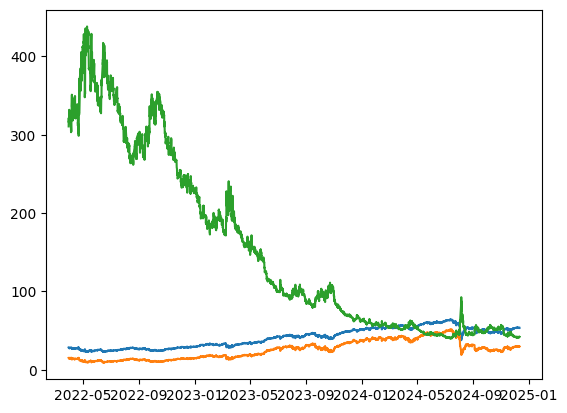

In [11]:
plt.plot(hf_df)

In [19]:
import datetime
from importlib import reload
import OptimizationEngine.mipEngine
reload(OptimizationEngine.mipEngine)

daily_dt = 10e3*60*60*24
min_dt = 10e3*60
dt_ratio = daily_dt / min_dt 

import time
def datetime_to_ms_epoch(dt):
    microseconds = time.mktime(dt.timetuple()) * 1000000 + dt.microsecond
    return int(round(microseconds / float(1000)))

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))
    
def getTimeDiffs(dt_list: np.array):
    ## case to ms unix tyime
    if type(dt_list[0]) == np.datetime64:
        dt_list = get_unixtime(dt_list)
    shifted_dt = np.roll(dt_list, 1)
    res = dt_list - shifted_dt
    res[0] = 0 ## as this makes no sense
    return res

logReturnTransform = lambda df : np.log(df.loc[:,~df.columns.str.contains('timestamp')]) - np.log(df.loc[:,~df.columns.str.contains('timestamp')].shift(1))
def logRetDtDailyTransform(df):
    return logReturnTransform(df.loc[:,~df.columns.str.contains('timestamp')]).apply(
        lambda col: np.asarray(col) / getTimeDiffs(np.asarray(df.index.values)) *math.sqrt(dt_ratio))

# print('Beta Adjustment on Mid-Frequency is: {0}.'.format(mf_betaAdj))

mf_summary = {}
for data in mf_bucket:
    mu = logReturnTransform(mf_bucket[data])['close'].mean()
    std = logReturnTransform(mf_bucket[data])['close'].std()
    mu_hf = logRetDtDailyTransform(hf_bucket[data])['close'].mean()
    std_hf = logRetDtDailyTransform(hf_bucket[data])['close'].std()
    mf_summary[data] = {"Mu": mu, "Sigma":std, "Beta":beta[data],
                        "Mu_Min": mu_hf, "Sigma_Min": std_hf}
mf_summary = pd.DataFrame(mf_summary)

mf_summary

,SVXY,SVIX,VIXY
Mu,0.000341,0.000780,-0.002464
Sigma,0.025541,0.043130,0.047509
Beta,-0.000241,-0.000147,0.000504
Mu_Min,0.001117,0.002818,-0.006474
Sigma_Min,0.259256,0.431222,0.476190


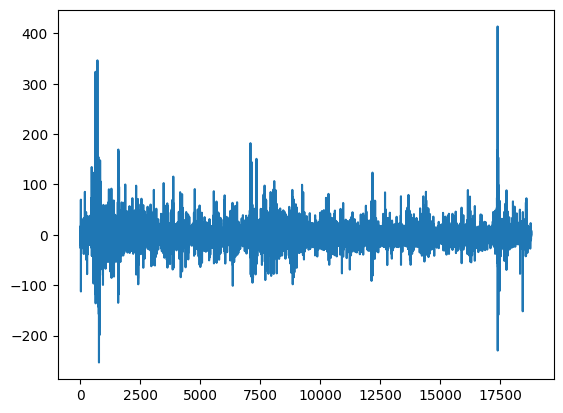

In [ ]:
plt.plot(logRetDtDailyTransform(hf_bucket[data])['close'])

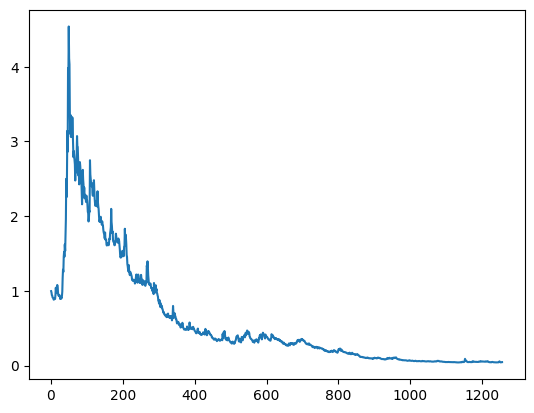

In [20]:
original = np.exp(logReturnTransform(mf_bucket['VIXY'])['close'])
plt.plot(original.cumprod())
# plt.plot(mf_bucket['PSQ'].index, mf_bucket['PSQ']['PSQ'])
# mf_bucket['PSQ']

## Running Ordinary Linear Regression for Weighting

In [21]:
hf_df.to_csv(r'C:\Users\raymo\OneDrive\Desktop\test.csv')

In [22]:
import pandas as pd
from numpy import arange
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold#define cross-validation method to evaluate model

def RidgeRegression(X,y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #define model
    model = RidgeCV(alphas=arange(0, 1, 0.01), 
                    cv=cv, 
                    scoring='neg_mean_absolute_error',
                    fit_intercept=False)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model


def ElasticNet(X,y, l1=0.5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    #define model
    model = ElasticNetCV(alphas=arange(0, 1, 0.01), 
                    cv=cv,
                    fit_intercept=False,
                    positive=True,
                    l1_ratio=l1)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model

In [23]:
def tls(X, y):
    """
    Performs Total Least Squares regression.

    Args:
        X (numpy.ndarray): Design matrix (n_samples, n_features)
        y (numpy.ndarray): Target vector (n_samples,)

    Returns:
        numpy.ndarray: Estimated coefficients (n_features,)
    """

    # Construct augmented matrix
    A = np.hstack((X, y.reshape(-1, 1)))

    # Perform SVD
    U, S, V = np.linalg.svd(A)

    # Extract coefficients
    Vxy = V[-1, :-1]
    Vyy = V[-1, -1]

    return -Vxy / Vyy

In [24]:
hf_df.columns[-1]

'VIXY'

In [25]:
# Define a function (quadratic in our case)
# to fit the data with.
# odr initially assumes a linear function
def f(B, x):
    return B[0] + np.dot(B[1:], x)  # B[0] is the intercept, B[1:] are the slopes

### log returns of high frequency data frame

# neutralizeBeta = lambda dcol: dcol[ticker] - mf_summary[ticker] for ticker in df)
hf_log = logReturnTransform(hf_df)
hf_log = pd.merge_asof(hf_log, logReturnTransform(bm_data), on = 'timestamp').dropna().set_index('timestamp')
components = list(hf_log.columns.values)
components.remove(bm_ticker)
### remove beta from FTW5000
hf_log[components] = hf_log[components].apply(lambda dcol: dcol - mf_summary.loc['Beta', dcol.name] 
                                                    *hf_log[bm_ticker] , axis = 0)
hf_log.drop(bm_ticker, axis=1, inplace=True) ## remove benchmark data
reference_ticker = 'VIXY' #hf_df.columns[0]
x_temp = hf_log.loc[:, ~hf_log.columns.str.contains(reference_ticker)]
x_temp = -1*x_temp.iloc[1:]


# x1=  np.array(x_temp['SPXS'])
# x2= np.array(x_temp['SPXU'])
# x3 = np.array(x_temp['SH'])
# x4=np.array(x_temp['SDS'])
# x = np.column_stack((x1,x2,x3,x4))
x = np.array(x_temp)
y = np.array(hf_log[reference_ticker].iloc[1:])

#  model fitting.
odr_model = odr.Model(f)
 
# Create a Data object using sample data created.
data = odr.Data(x, y)
 
# # Set ODR with the model and data.
# ordinal_distance_reg = odr.ODR(data, odr_model,
#                                beta0=[0] + [1]*x.shape[1])
 
# # Run the regression.
# out = ordinal_distance_reg.run()
 
# # print the results
# out.pprint()

# ElasticNet(x,y, 0)
coeffs_ = RidgeRegression(x,y).coef_

# # Plot the data and the fit
# plt.scatter(x, y)
# plt.plot(x, out.beta[0] * x + out.beta[1], color='red')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Orthogonal Linear Regression')
# plt.show()

[1.28584771 0.27923197]


Hurst:  0.35398340165465497


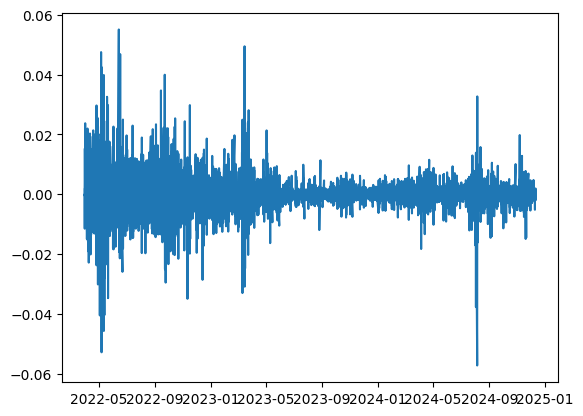

In [26]:
def hurst(ts):
    """Calculates the Hurst Exponent of the time series vector ts"""

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0

elementExp = lambda row, coeffs: np.power(np.array(row), coeffs_)
positive_legs = hf_df.loc[:, ~hf_df.columns.str.contains(reference_ticker)]
signal = positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)
signal = signal.add(hf_df[reference_ticker])
raw = pd.DataFrame(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)).join(hf_df[reference_ticker])
print('Hurst: ', hurst(np.array(signal.resample('1D').agg('last').dropna())))
# plt.hist(signal.pct_change(),bins=100)
plt.plot(signal.pct_change())
# plt.scatter(logReturnTransform(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)),
#             logReturnTransform(hf_df[reference_ticker]))

In [27]:
reload(DataExtensions)
outlier_idxs = DataExtensions.zscoreOutliers(signal.pct_change(), params={'std':6})
## these are looking for stock splits 
win1 = outlier_idxs[0]
hf_df[win1[0] - pd.Timedelta(days=2):win1[1]+ pd.Timedelta(days=2)]

,SVXY,SVIX,VIXY
timestamp,,,
2022-05-02 08:00:00,23.8350,10.5900,414.000
2022-05-02 10:00:00,23.9400,10.5900,409.600
2022-05-02 11:00:00,23.6550,10.4000,419.000
2022-05-02 12:00:00,23.7100,10.4200,418.000
2022-05-02 13:00:00,23.7000,10.4800,418.000
2022-05-02 14:00:00,23.7300,10.4450,416.600
2022-05-02 15:00:00,23.5000,10.2500,424.400
2022-05-02 16:00:00,23.4350,10.2000,427.000
2022-05-02 17:00:00,23.4050,10.1600,428.200


In [28]:
# ### find new beta of signal to benchmark
# from BetaModels.BetaCovFactory import BetaCovFactory
# daily_signal = pd.DataFrame(signal.resample('1D').last().dropna(),
#                             columns=['DailySignal'])
# print(daily_signal)
# bm_ticker = "^FTW5000"

# ## extract benchmark data 
# yf_res = yf.Ticker(bm_ticker)
# info = yf_res.info
# # get historical market data
# hist = yf_res.history(interval="1D", period='5y').rename(columns={'Close':bm_ticker})
# hist = hist.tz_localize(None)
# #hist.index = hist.index.normalize()
# bm_data = hist[[bm_ticker]].rename(columns={'Date':'timestamp'})
# bmFactory = BetaCovFactory(logReturnTransform(bm_data)[1:])
# signalBeta = bmFactory.calculateBeta(logReturnTransform(daily_signal)[1:])[0]
# signalBeta

Signal = pd.DataFrame(signal, columns=['Signal'])
# Signal['timestamp'] = [datetime_to_ms_epoch(ts) for ts in Signal['timestamp']]
Signal

,Signal
timestamp,
2022-03-30 13:00:00,386.248420
2022-03-30 14:00:00,392.020141
2022-03-30 15:00:00,392.512310
2022-03-30 16:00:00,391.320059
2022-03-30 17:00:00,390.253449
...,...
2024-12-10 19:00:00,210.852423
2024-12-10 20:00:00,210.418796
2024-12-10 21:00:00,210.328796


In [29]:
Signal

,Signal
timestamp,
2022-03-30 13:00:00,386.248420
2022-03-30 14:00:00,392.020141
2022-03-30 15:00:00,392.512310
2022-03-30 16:00:00,391.320059
2022-03-30 17:00:00,390.253449
...,...
2024-12-10 19:00:00,210.852423
2024-12-10 20:00:00,210.418796
2024-12-10 21:00:00,210.328796


In [30]:
reference_ticker

'VIXY'

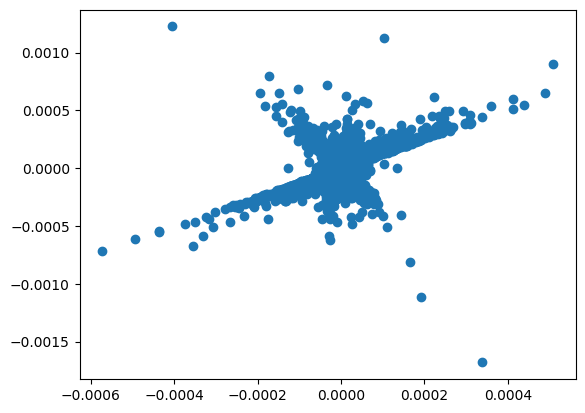

In [31]:
plt.scatter(logRetDtDailyTransform(Signal),
            logRetDtDailyTransform(pd.DataFrame(hf_df[reference_ticker])))

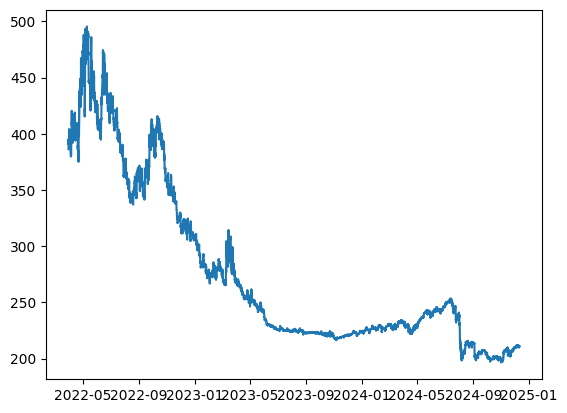

In [32]:
plt.plot(Signal)

c:\Users\raymo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Text(0, 0.5, 'Value')

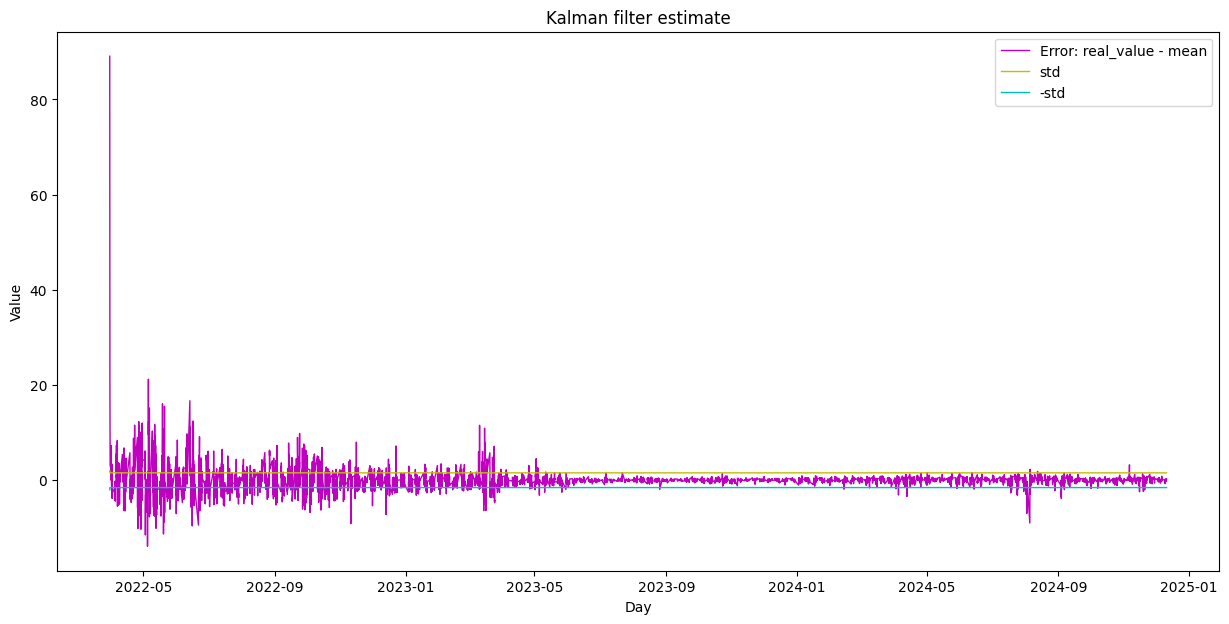

In [34]:
## Filtering
# filter = KalmanFilter(raw)
reload(KalmanFilter)
names = [0, 'VIXY']#['AIQ',0]
means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', Signal, 
                                                     np.mean(Signal[-252:]),
                                                     np.var(Signal[-252:]))
# Create subplots with shared axes
# fig, axes = plt.subplots(1, 2, sharex=True)
# # Plot data on each subplot
# axes[0].plot(Signal.index, means.squeeze())
# axes[1].plot(Signal.index, covs.squeeze())

mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'] - mean, 'm', lw=1)
plt.plot(Signal.index, np.sqrt(covs.squeeze()), 'y', lw=1)
plt.plot(Signal.index, - np.sqrt(covs.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

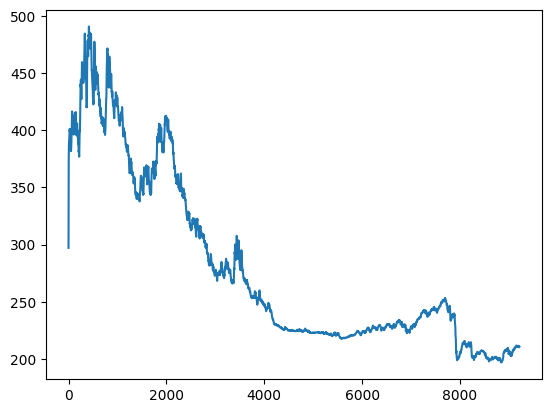

In [37]:
"""
Need to check math on regression on return back to signal level.
logret(Y) = Beta*logret(X) [assume  centered 0]
log(Y) - log(Y') = Beta*(log(X) - log(X'))
log(Y) - log(Y') = log(sum_i x_i^beta_i) - log(sum_i x'_i^beta_i)

"""
state_means, state_covs =means, covs 
plt.plot(state_means)#, state_covs
# DataExtensions.draw_slope_intercept_changes(Signal, state_means)

[297.15897926 333.58190042 353.41388565 ... 210.55695557 210.60771827
 210.703456  ]


Text(0, 0.5, 'Residuals')

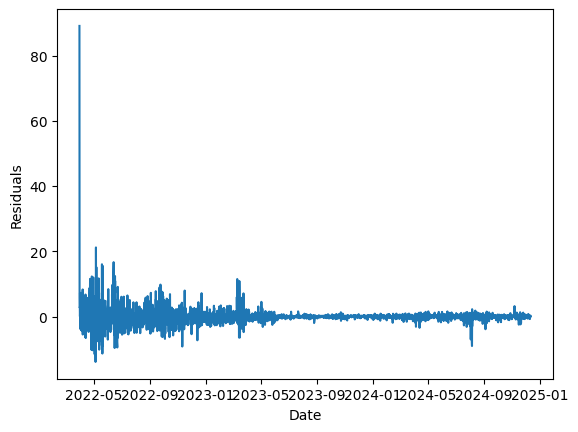

In [41]:
state_means0 = np.array(pd.DataFrame(state_means)[0])
print(state_means0)
resid = Signal['Signal'] - state_means0
stdev = []
for i in range(len(resid)):
    stdev.append(math.sqrt(state_covs[i][0][0]))
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

## Portfolio Optimization

In [ ]:
bounds = {'Mu':0, 'Sigma':0, 'Beta':0, 'Mu_Min':0, 'Sigma_Min':0}
MIP = OptimizationEngine.mipEngine.mipEngine()
# MIP._addVariables(mf_summary.columns, var_bounds=(None,None), var_type="INTEGER")
MIP._addConstraints(mf_summary, bounds, var_bounds=(1,None))
MIP._optimize()
#pd.DataFrame(mf_summary)

In [38]:
raw = raw.reset_index().set_index('timestamp')
raw

,0,VIXY
timestamp,,
2022-03-30 13:00:00,75.648420,310.600
2022-03-30 14:00:00,74.620141,317.400
2022-03-30 15:00:00,74.498310,318.014
2022-03-30 16:00:00,74.720059,316.600
2022-03-30 17:00:00,74.913449,315.340
...,...,...
2024-12-10 19:00:00,169.252423,41.600
2024-12-10 20:00:00,168.568796,41.850
2024-12-10 21:00:00,168.568796,41.760


In [39]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
## analysis between adr spread and volume pct
df = signal

df.fillna(method='ffill', inplace=True)
# df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_Volume'] +df['TSM_Volume'])
mean = df.mean()
std = df.std()
# df['ADR_Vol_Pct'] = (df['ADR_Vol_Pct'] - mean)/std
# df['ADR_Spread'] = df['TSM_Close'] - df['TSMC34_SA_Close']
# mean = df['ADR_Spread'].mean()
# std = df['ADR_Spread'].std()
# df['ADR_Spread'] = (df['ADR_Spread'] - mean)/std
coint_test_result = coint_johansen(raw, det_order=1, k_ar_diff=0)
tracevalues = coint_test_result.lr1
critical_values = coint_test_result.cvt
for i, (stock1, stock2) in enumerate([list(raw.columns.values)]):
    if (tracevalues[i] > critical_values[:, 1]).all():
        print(f"Pair {i + 1} ({stock1} and {stock2}) is cointegrated.")
    else:
        print(f"Pair {i + 1} ({stock1} and {stock2}) is not cointegrated.")

Pair 1 (0 and VIXY) is not cointegrated.


C:\Users\raymo\AppData\Local\Temp\ipykernel_27936\246132147.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [88]:

# df['ADR_Vol_MA20'] = df['ADR_Vol_Pct'].rolling(20).mean()
# df['ADR_1sd_MA20'] = df['ADR_Vol_Pct'].rolling(20).std()
# df['primitive_signal'] = df.apply(lambda dr: 1 if dr.ADR_Vol_Pct < dr.ADR_Vol_MA20 - dr.ADR_1sd_MA20 else 0, axis=1).rolling(5).mean()
# ## add persistence to signal - to optimize
# df['Signal'] = [1 if x > 0 else 0 for x in df['primitive_signal']]
# df['BuySell'] = df['Signal'] - df['Signal'].shift(1)
# df["index"] = pd.to_datetime(df["index"])
# df

df = pd.DataFrame()
df['primitive_signal'] = Signal['Signal']
df = df.merge(hf_df, on='timestamp', how='left')
df['filter_resid'] = resid
df['filter_spread'] = stdev

def simpleFilterSignal(dr, epsilon):
    if dr.filter_resid < -dr.filter_spread*epsilon:
        return 1
    elif dr.filter_resid > dr.filter_spread*epsilon:
        return -1
    else:
        return 0

df['Signal'] = df.apply(lambda dr: simpleFilterSignal(dr, 3), axis=1)
df['BuySell'] = df['Signal'] - df['Signal'].shift(1)
df = df.reset_index().rename(columns={"timestamp":"Date"})
df

,Date,primitive_signal,SVXY,SVIX,VIXY,filter_resid,filter_spread,Signal,BuySell
0,2022-03-30 13:00:00,386.248420,28.2800,15.06,310.600,89.089441,2.013969,-1,NaN
1,2022-03-30 14:00:00,392.020141,27.9750,14.80,317.400,58.438241,1.764863,-1,0.0
2,2022-03-30 15:00:00,392.512310,27.9400,14.67,318.014,39.098424,1.652270,-1,0.0
3,2022-03-30 16:00:00,391.320059,28.0051,14.79,316.600,25.966613,1.598479,-1,0.0
4,2022-03-30 17:00:00,390.253449,28.0625,14.84,315.340,17.312724,1.572212,-1,0.0
...,...,...,...,...,...,...,...,...,...
9209,2024-12-10 19:00:00,210.852423,53.4499,29.59,41.600,0.102422,1.546524,0,0.0
9210,2024-12-10 20:00:00,210.418796,53.2800,29.48,41.850,-0.233554,1.546524,0,0.0
9211,2024-12-10 21:00:00,210.328796,53.2800,29.48,41.760,-0.228159,1.546524,0,0.0
9212,2024-12-10 22:00:00,210.729129,53.3300,29.48,41.960,0.121411,1.546524,0,0.0


In [98]:
type(df.Date[0]-df.Date[1])

pandas._libs.tslibs.timedeltas.Timedelta

In [114]:
row.Date.normalize()

Timestamp('2024-12-11 00:00:00')

In [120]:
BBO = order_book.Book()
HOLDING_PERIOD_CHECK = {}
isLong = False

def isFirstTrade(ticker, date):
    if ticker not in HOLDING_PERIOD_CHECK:
        return True
    if date not in HOLDING_PERIOD_CHECK[ticker]:
        return True
    return False

for row in df.itertuples():
    if (row.BuySell == 1 
        and not isLong
        and isFirstTrade("SVIX", row.Date.normalize())):
        print('bought spread at ', row.index)
        BBO.addOrder(row.Date, "SVIX", row.SVIX, -10)
        BBO.addOrder(row.Date, "VIXY", row.VIXY, 10)
        if "SVIX" not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK["SVIX"] = []
        HOLDING_PERIOD_CHECK['SVIX'].append(row.Date.normalize())
        isLong = True
    elif (row.BuySell == -1 
          and isLong
          and isFirstTrade("SVIX", row.Date.normalize())):
        print('sold spread at ', row.Date)
        BBO.addOrder(row.Date, "SVIX", row.SVIX, 10)
        BBO.addOrder(row.Date, "VIXY", row.VIXY, -10)
        isLong = False
        if "SVIX" not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK["SVIX"] = []
        HOLDING_PERIOD_CHECK['SVIX'].append(row.Date.normalize())
#BBO.addOrder(df_res.iloc[100]["Date"], "TSM", 300.0, 10)
#BBO.addOrder(df_res.iloc[120]["Date"], "TSM", 250.0, 25)
#BBO.addOrder(df_res.iloc[200]["Date"], "TSM", 350.0, -30)
#BBO.getTickerBook(["TSLA"]).tail(1)#.loc['Quantity']
#BBO.get_history()

#BBO.addOrder(df_res.iloc[50]["Date"], "TSMC34.SA", 300.0, 10)
#BBO.addOrder(df_res.iloc[150]["Date"], "TSMC34.SA", 250.0, -25)

bought spread at  <built-in method index of Pandas object at 0x000001E182CB0EC0>
sold spread at  2022-03-31 19:00:00
bought spread at  <built-in method index of Pandas object at 0x000001E182CCAE40>
sold spread at  2022-04-06 08:00:00
bought spread at  <built-in method index of Pandas object at 0x000001E182CCAE40>
sold spread at  2022-04-08 17:00:00
bought spread at  <built-in method index of Pandas object at 0x000001E182DFA040>
sold spread at  2022-04-12 14:00:00
bought spread at  <built-in method index of Pandas object at 0x000001E182CCAE40>
sold spread at  2022-04-18 08:00:00
bought spread at  <built-in method index of Pandas object at 0x000001E182CCAE40>
sold spread at  2022-04-21 15:00:00
bought spread at  <built-in method index of Pandas object at 0x000001E182CCAE40>
sold spread at  2022-04-25 08:00:00
bought spread at  <built-in method index of Pandas object at 0x000001E182CCAE40>
sold spread at  2022-04-27 10:00:00
bought spread at  <built-in method index of Pandas object at 0x0

In [121]:
BBO.getOrderDf()

,Date,Ticker,Price,Quantity,Longshort
0,2022-03-30 22:00:00,SVIX,14.8000,-10,False
1,2022-03-30 22:00:00,VIXY,315.8000,10,True
2,2022-03-31 19:00:00,SVIX,14.0700,10,True
3,2022-03-31 19:00:00,VIXY,331.8320,-10,False
4,2022-04-05 16:00:00,SVIX,14.6338,-10,False
...,...,...,...,...,...
197,2023-03-24 11:00:00,VIXY,219.6000,10,True
198,2024-08-02 15:00:00,SVIX,32.9014,10,True
199,2024-08-02 15:00:00,VIXY,59.0000,-10,False
200,2024-08-05 08:00:00,SVIX,23.9000,-10,False


In [122]:

df1 = df[['Date', 'SVIX']]
df2 = df[['Date', 'VIXY']]
df1['Ticker'] = 'SVIX'
df2['Ticker'] = 'VIXY'

df_res = pd.concat([df1.rename(columns={'SVIX':'Price'}),df2.rename(columns={'VIXY':'Price'})])
print(df_res)
#df1.drop('index', inplace=True)
#df_res.rename(columns={'Datetime':'Date'}, inplace=True)
BBO.backfillPnL(df_res)

                    Date  Price Ticker
0    2022-03-30 13:00:00  15.06   SVIX
1    2022-03-30 14:00:00  14.80   SVIX
2    2022-03-30 15:00:00  14.67   SVIX
3    2022-03-30 16:00:00  14.79   SVIX
4    2022-03-30 17:00:00  14.84   SVIX
...                  ...    ...    ...
9209 2024-12-10 19:00:00  41.60   VIXY
9210 2024-12-10 20:00:00  41.85   VIXY
9211 2024-12-10 21:00:00  41.76   VIXY
9212 2024-12-10 22:00:00  41.96   VIXY
9213 2024-12-11 00:00:00  41.96   VIXY

[18428 rows x 3 columns]


C:\Users\raymo\AppData\Local\Temp\ipykernel_27936\2903296011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Ticker'] = 'SVIX'
C:\Users\raymo\AppData\Local\Temp\ipykernel_27936\2903296011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Ticker'] = 'VIXY'


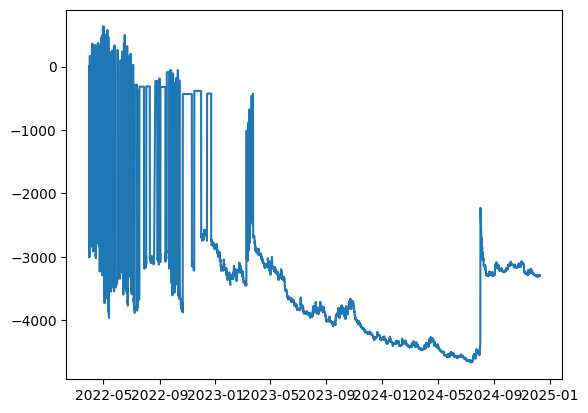

In [127]:
hist = BBO.getHistoryDf()
plt.plot(hist['PnL'])
plt.show()

In [125]:
BBO.get_books()

,Date,Ticker,Quantity,CostBasis,MV,UnrealizedPnL,Cash
0,2022-03-30 22:00:00,SVIX,-10,-148.000,-148.000,0.000,148.000
1,2022-03-30 22:00:00,VIXY,10,3158.000,3158.000,0.000,-3158.000
2,2022-03-31 19:00:00,SVIX,0,0.000,0.000,7.300,7.300
3,2022-03-31 19:00:00,VIXY,0,0.000,0.000,160.320,160.320
4,2022-04-05 16:00:00,SVIX,-10,-146.338,-146.338,0.000,153.638
...,...,...,...,...,...,...,...
197,2023-03-24 11:00:00,VIXY,10,2196.000,2196.000,0.000,-2636.620
198,2024-08-02 15:00:00,SVIX,0,0.000,0.000,-193.214,-180.211
199,2024-08-02 15:00:00,VIXY,0,0.000,0.000,-1606.000,-2046.620
200,2024-08-05 08:00:00,SVIX,-10,-239.000,-239.000,0.000,58.789


In [ ]:
hist